In [21]:
# imports
import xlrd
import numpy as np
import numpy.ma as ma
import datetime
import matplotlib.pyplot as plt
import itertools
import matplotlib.pyplot as plt
from matplotlib.finance import candlestick_ohlc, candlestick2_ohlc
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
from IPython.display import HTML, display
from collections import OrderedDict

%matplotlib inline

In [2]:
# constants
LONG_INTERVAL = np.timedelta64(21, 'm')
SHORT_INTERVAL = np.timedelta64(1, 'm')
std_factor = 2
bid_factor = 0.6
ask_factor = 0.6
figsize = (20, 10)
linewidth = 1

In [3]:
def read_data(filepath):
    """
    Reads .xls file and returns time, price and sell
    """
    book = xlrd.open_workbook(filepath)
    sheet = book.sheet_by_index(0)
    events_times = sheet.col_values(3)[1:]
    prices = sheet.col_values(4)[1:]
    sells = sheet.col_values(6)[1:]
    
    price = np.array(prices)
    sell = np.array(sells, dtype='bool')
    events_times = np.array([str(datetime.datetime.fromtimestamp(d/1000)) for d in events_times], dtype='datetime64')   
    
    return events_times, prices, sells

In [4]:
def calc_times(events_times):
    """
    Returns numpy array of closing times.
    """
    start_time = events_times[0]
    end_time = events_times[-1] + np.timedelta64(1, 'm')
    
    return np.arange(start_time, end_time, SHORT_INTERVAL, dtype='datetime64')[1:]    

In [5]:
def intervals_data(event_time, closing_time, price, sell):
    """
    Return data for itervals.
    """
    data = np.empty(shape = [len(closing_time), 8],dtype=float)

    for i, time in enumerate(closing_time):        
        start_time_long = time - LONG_INTERVAL
        long_mask = (event_time < start_time_long) | (time < event_time)
        if long_mask.all():
            mean = data[i-1][0]
            std = data[i-1][1]        
        else:
            masked_price = ma.masked_array(price, long_mask)
            mean = masked_price.mean()
            std = masked_price.std()

        start_time_short = time - SHORT_INTERVAL
        short_mask = (event_time < start_time_short) | (time < event_time)
        if short_mask.all():
            open_ = np.nan
            high = np.nan
            low = np.nan
            close = np.nan
            bid = np.nan       
            number_of_events = 0
        else:
            masked_price = ma.masked_array(price, short_mask)
            
            open_ = masked_price.compressed()[0]
            high = masked_price.max()
            low = masked_price.min()
            close = masked_price.compressed()[-1]
            
            bid = ma.masked_array(sell, short_mask).mean()
            number_of_events = len(ma.masked_array(price, short_mask).compressed())        

        data[i][0] = mean
        data[i][1] = std
        data[i][2] = open_
        data[i][3] = high
        data[i][4] = low
        data[i][5] = close
        data[i][6] = bid        
        data[i][7] = number_of_events
        
    return data

In [6]:
def calculate_trades(closing_times, data, std_factor, ask_factor, bid_factor):
    """
    Return trades.
    """
    buy_cond = False
    buy_cond_now = False
    buy = False
    trades = []
    trade_times = []

    for i, el in enumerate(data[:-1]):
        # check if buy: close < -2 std
        open_next = data[i+1][2] # OK
        amount_next = data[i+1][7] #OK
        time_next = closing_times[i+1] #OK
        close = el[5]
        mean = el[0]
        std = el[1]
        bid = el[6]

        if ~np.isnan(open_next):
            buy_cond_previous = buy_cond_now
            if close < mean - std_factor * std and bid > bid_factor: # buy_ and buy_A
                buy_cond_now = True # check current buy
            else:
                buy_cond_now = False

            if buy_cond_previous == True and (1-bid) > ask_factor and buy == False: # buy_B
                trades.append(open_next) 
                trade_times.append(time_next)            
                buy = True
                continue        

            if close > mean and buy == True: # check current sell            
                trades.append(open_next)
                trade_times.append(time_next)
                buy = False
    
    return np.array(trade_times), np.array(trades) 

In [7]:
def calculate_equity(trade_times, trades):
    """
    """
    value_initial = trades[0::2]
    value_final = trades[1::2]
    
    time = trade_times[1::2]
    
    r = (value_final-value_initial)/value_initial
    r1 = r+1    
    equity = np.cumprod(r1)-1
    
    return time, equity, r

In [8]:
def consecutive_values(array):
    """
    Return list of consecutive True values in array 
    """        
    bounded = np.hstack(([0], array, [0]))
    
    difs = np.diff(bounded)
    run_starts, = np.where(difs > 0)
    run_ends, = np.where(difs < 0)
    return run_ends - run_starts

In [9]:
def max_drawdown(vec):
    """
    Maximum Drawodn of vec.
    """
    maximums = np.maximum.accumulate(vec)
    drawdowns = 1 - vec / maximums
    return np.max(abs(drawdowns))

In [10]:
events_times, prices, sells = read_data("Kraken podatki.xlsx")
closing_times = calc_times(events_times)
data = intervals_data(events_times, closing_times, prices, sells)
trade_times, trades = calculate_trades(closing_times, data, std_factor, ask_factor, bid_factor)

In [11]:
for i, trade in enumerate(trades):
    action = "buy " if i%2 == 0 else "sell"
    print(action, trade_times[i], trade)

buy  2017-08-01T07:48:02.033000 2949.0
sell 2017-08-01T07:52:02.033000 2945.066
buy  2017-08-01T13:26:02.033000 2841.0
sell 2017-08-01T13:52:02.033000 2823.0
buy  2017-08-01T17:37:02.033000 2691.0
sell 2017-08-01T17:45:02.033000 2692.092
buy  2017-08-01T22:11:02.033000 2767.022
sell 2017-08-01T22:40:02.033000 2753.8
buy  2017-08-01T22:52:02.033000 2750.098
sell 2017-08-01T22:53:02.033000 2757.498
buy  2017-08-02T00:29:02.033000 2727.821
sell 2017-08-02T00:30:02.033000 2730.0
buy  2017-08-02T00:50:02.033000 2721.6
sell 2017-08-02T01:17:02.033000 2706.768


In [12]:
time, equity, r = calculate_equity(trade_times, trades)

In [13]:
standard_deviation_of_equity_curve = equity.std()
donwside_deviaton_of_equity_curve = equity[equity < 0].std()
percent_of_winning_trades = len(r[r > 0])/len(r)
percent_of_loosing_trades = len(r[r < 0])/len(r)
average_winning_trade = r[r > 0].mean()
average_loosing_trade = r[r < 0].mean()
consecutive_winning_trades = consecutive_values(r > 0).max()
consecutive_loosing_trades = consecutive_values(r < 0).max()
compounded_average_growth_rate_or_equity_curve = ((1+equity[-1])/1)**(1/(1/356))-1
maximum_drawdown_of_equity_curve = max_drawdown(equity)

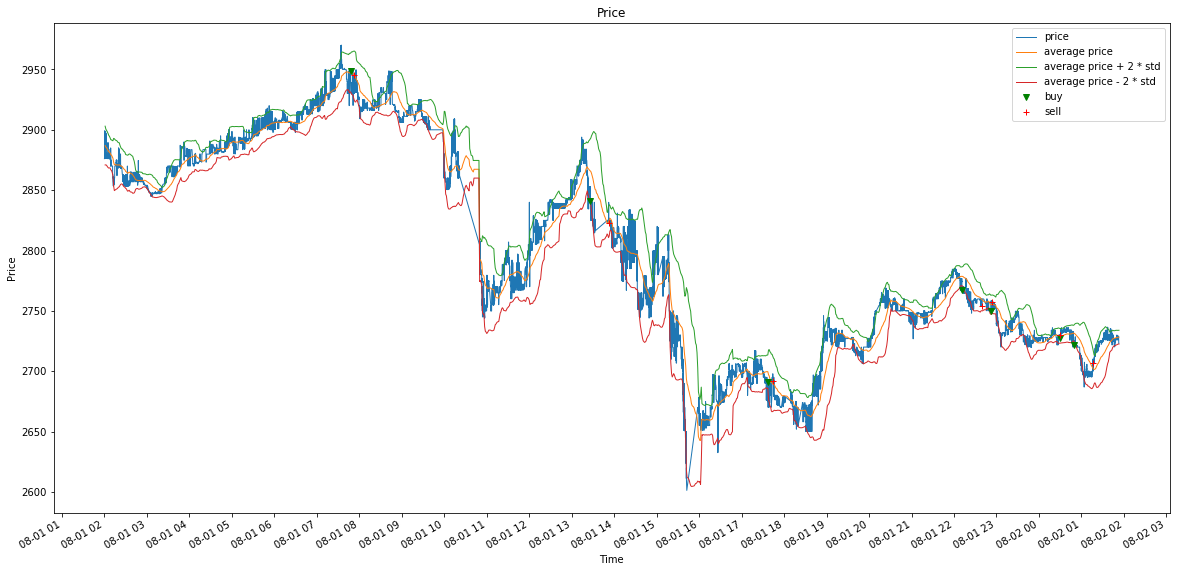

In [14]:
# data 
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)
ax.plot(events_times.astype(datetime.datetime), prices, label="price", linewidth= linewidth)
ax.plot(closing_times.astype(datetime.datetime), data[:,0], label="average price", linewidth= linewidth)
ax.plot(closing_times.astype(datetime.datetime), data[:,0]+std_factor*data[:,1], label="average price + 2 * std", linewidth= linewidth)
ax.plot(closing_times.astype(datetime.datetime), data[:,0]-std_factor*data[:,1], label="average price - 2 * std", linewidth= linewidth)

ax.plot(trade_times[0::2].astype(datetime.datetime), trades[0::2], 'gv', label="buy" )
ax.plot(trade_times[1::2].astype(datetime.datetime), trades[1::2], 'r+', label="sell")

ax.set_title('Price')
ax.set_xlabel('Time')
ax.set_ylabel('Price')
fig.autofmt_xdate()
ax.xaxis.set_major_locator(mdates.HourLocator())
ax.legend()
plt.show()

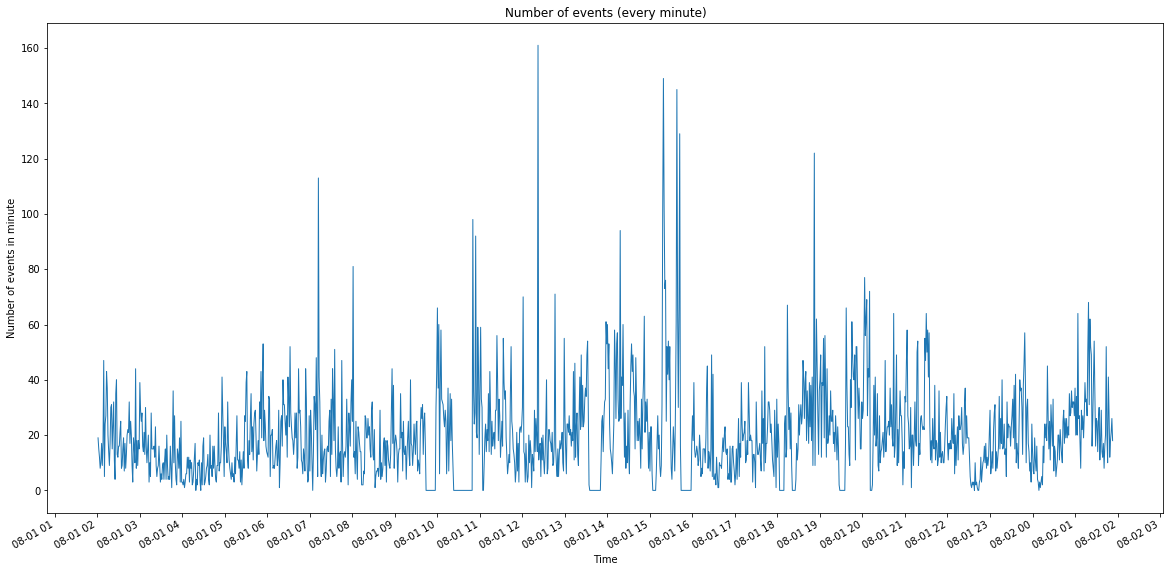

In [15]:
# number of events
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)
ax.plot(closing_times.astype(datetime.datetime), data[:,7], linewidth= linewidth)
ax.set_title('Number of events (every minute)')
ax.set_xlabel('Time')
ax.set_ylabel('Number of events in minute')
fig.autofmt_xdate()
ax.xaxis.set_major_locator(mdates.HourLocator() )
plt.show()

In [16]:
# OHLC curve

buy_times = trade_times[0::2]
sell_times = trade_times[1::2]
buy_indices = [np.where(time == closing_times) for time in buy_times]
sell_indices = [np.where(time == closing_times) for time in sell_times]
buy_indices = np.concatenate(buy_indices).flatten()
sell_indices = np.concatenate(sell_indices).flatten()


def plot_ohlc(start_index, end_index):
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)
    candlestick2_ohlc(ax, data[:,2], data[:,3], data[:,4], data[:,5], width=0.8)
    ax.plot(data[:,0], label="average price", linewidth= linewidth)
    #ax.plot(data[:,0]+std_factor*data[:,1], label="average price + 2 * std", linewidth= linewidth, markersize=24)
    ax.plot(data[:,0]-std_factor*data[:,1], label="average price - 2 * std", linewidth= linewidth, markersize=12)

    xdate = closing_times.astype(datetime.datetime)
    ax.xaxis.set_major_locator(ticker.MaxNLocator(20))

    def mydate(x,pos):
        try:
            return xdate[int(x)]
        except IndexError:
            return ''
    fig.autofmt_xdate()
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(mydate))

    ax.plot(buy_indices, trades[0::2], 'gv', label="buy", markersize=15)
    ax.plot(sell_indices, trades[1::2], 'm^', label="sell", markersize=15)
    
    ax.set_xlim(start_index-10, end_index+10)
    
    ymax = np.nanmax(data[start_index:end_index,3])+ 10
    ymin = np.nanmin(data[start_index:end_index,4])-10
    
    ax.set_ylim(ymin, ymax)
    
    ax.legend()

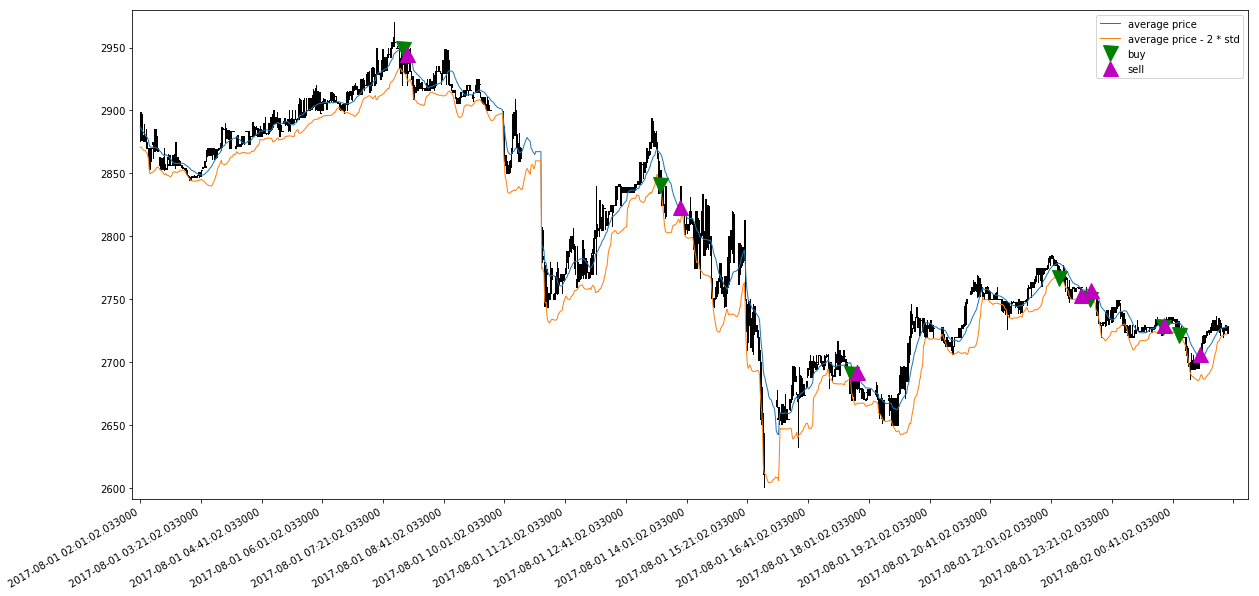

In [17]:
plot_ohlc(0, 1450)

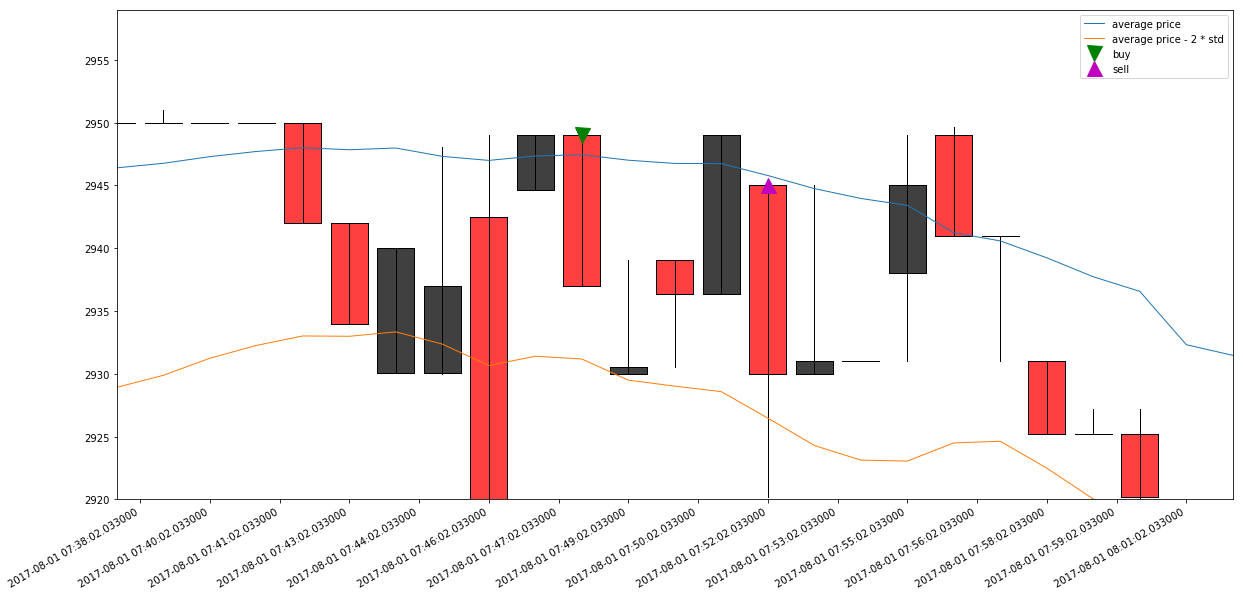

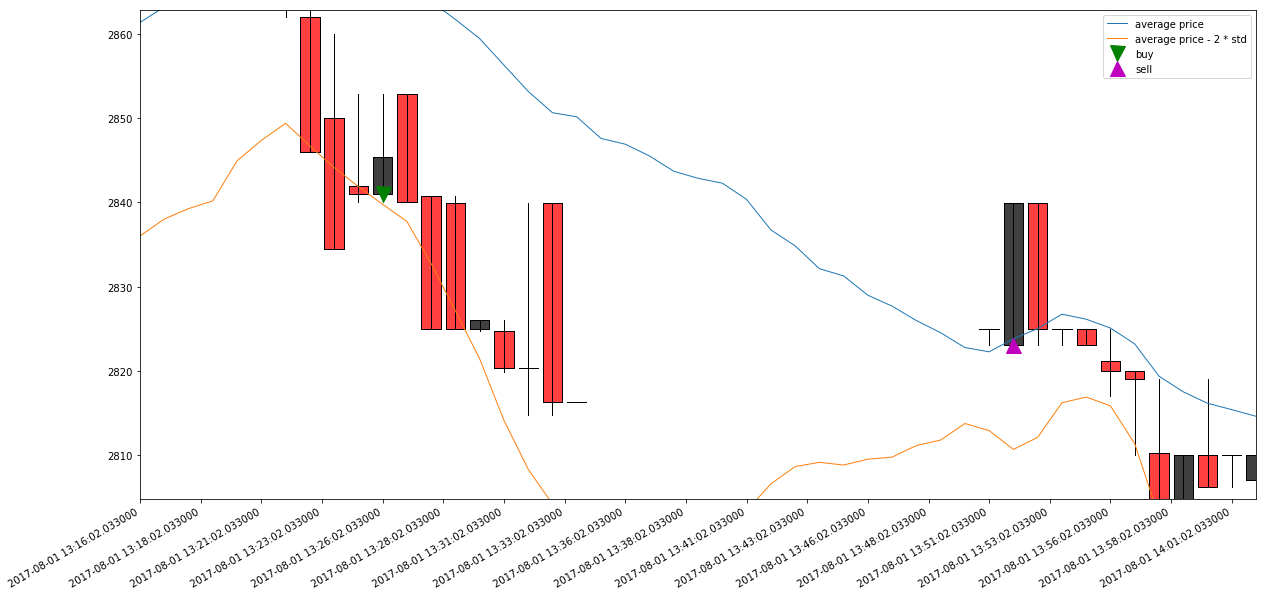

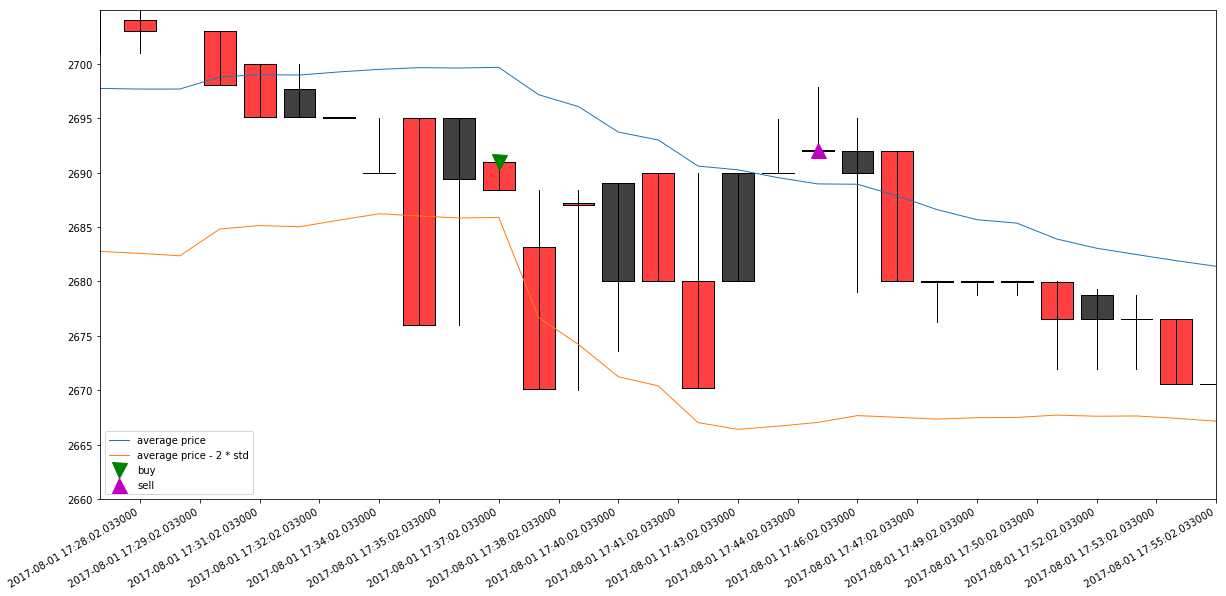

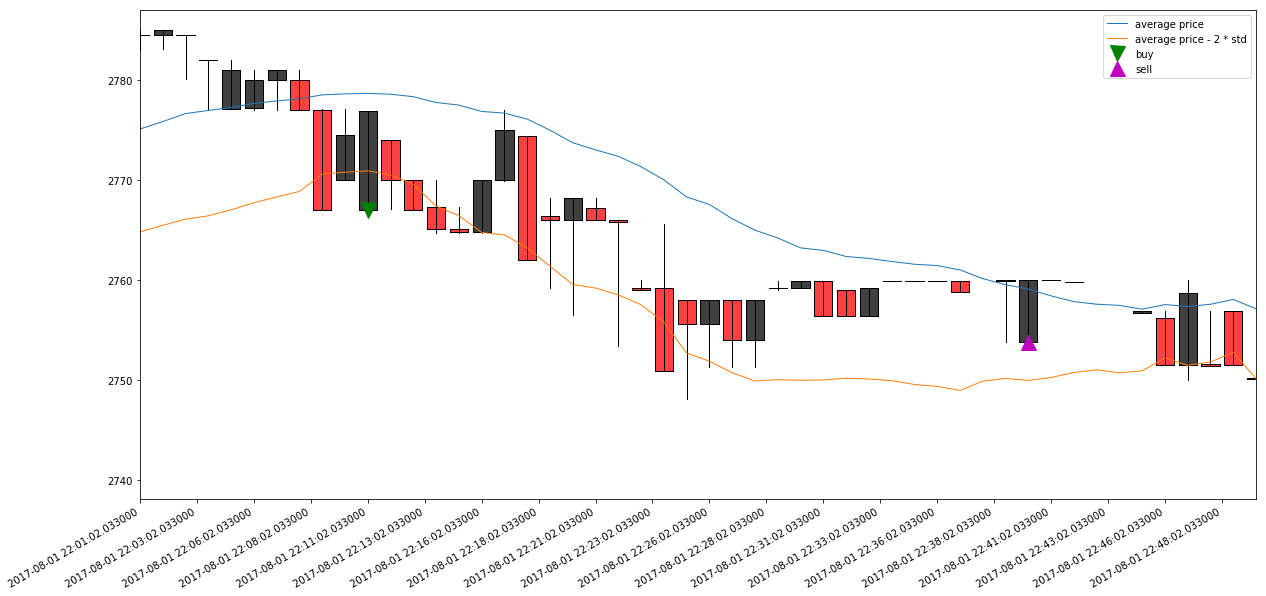

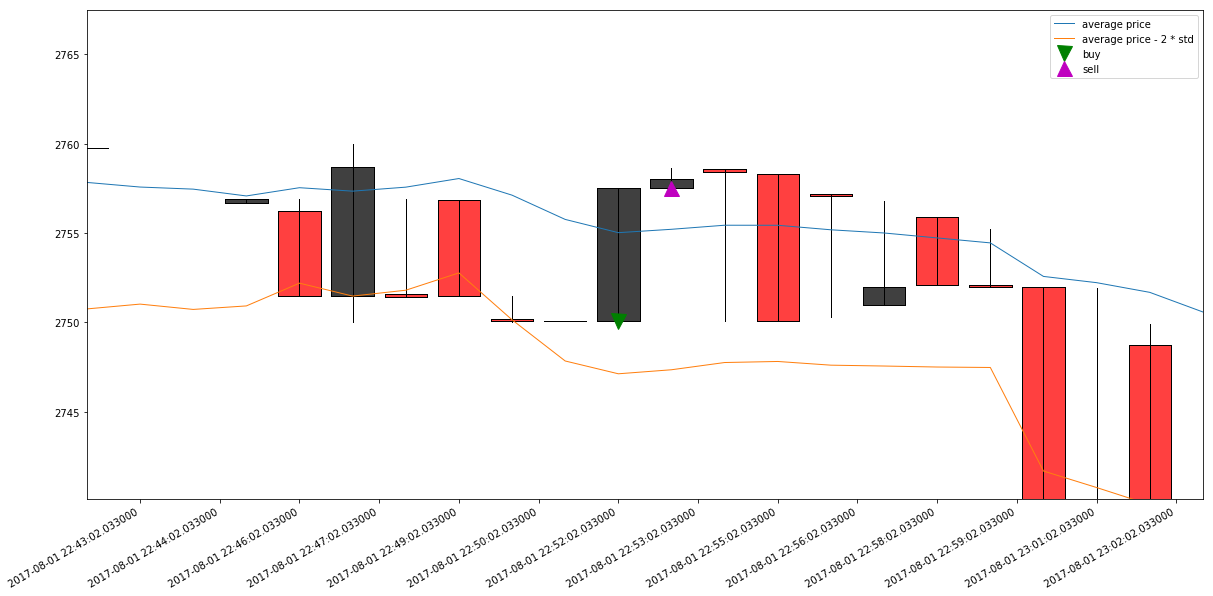

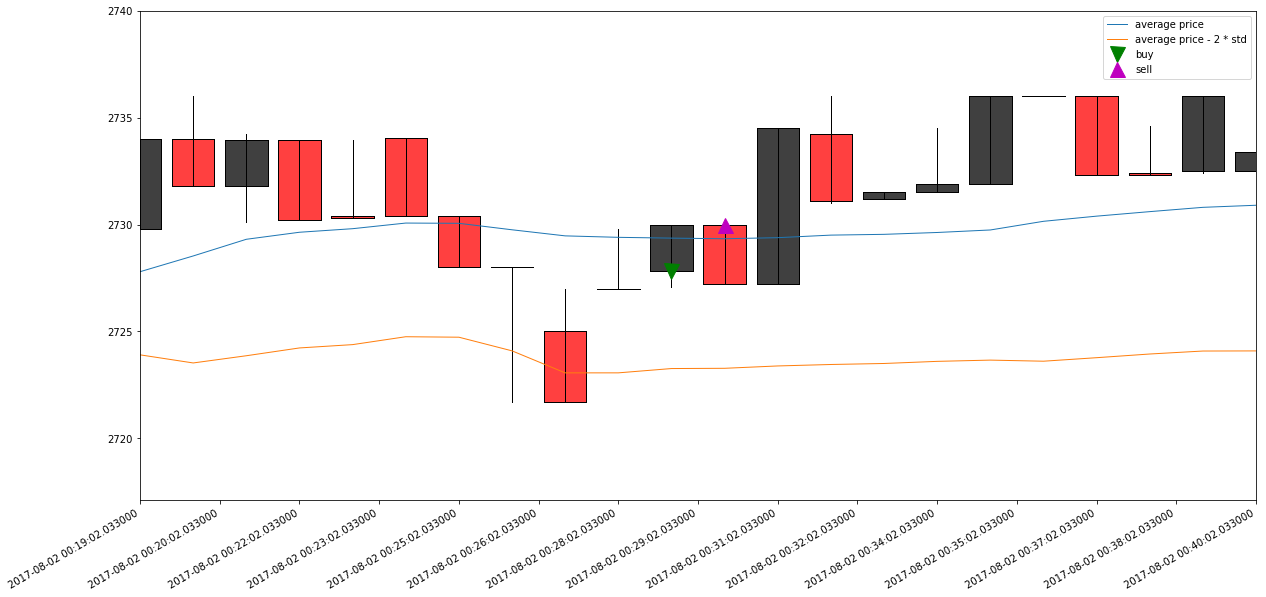

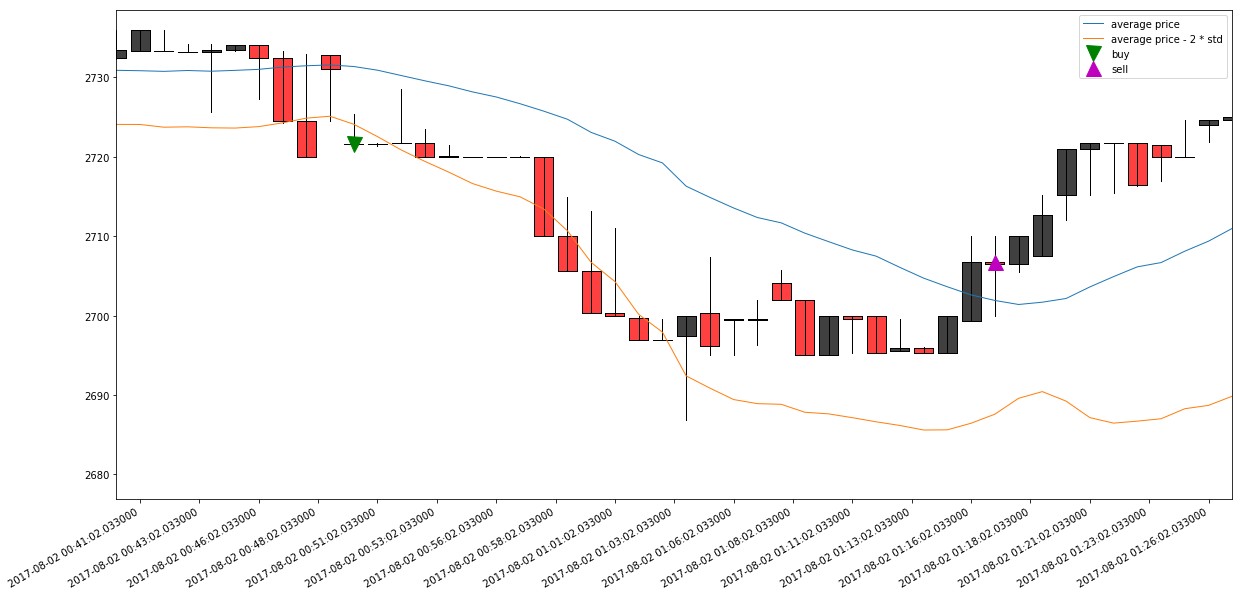

In [18]:
for i in range(7):
    plot_ohlc(buy_indices[i], sell_indices[i])

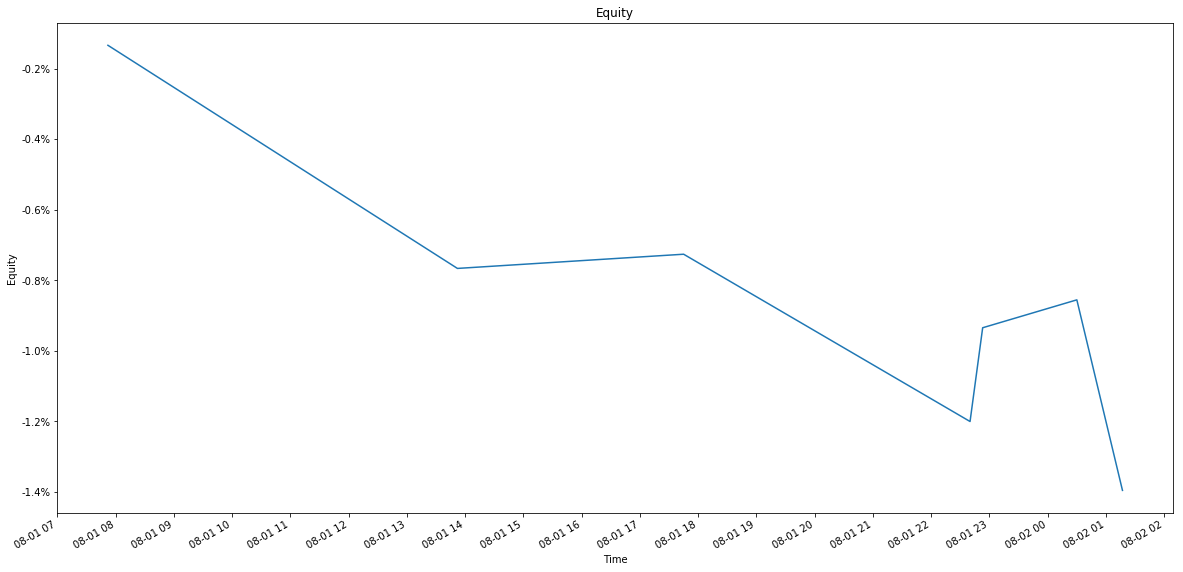

In [19]:
# equity curve
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)
ax.plot(time.astype(datetime.datetime), equity)
ax.set_title('Equity')
ax.set_xlabel('Time')
ax.set_ylabel('Equity')
fig.autofmt_xdate()
ax.xaxis.set_major_locator(mdates.HourLocator() )
ax.set_yticklabels(['{:3.1f}%'.format(x*100) for x in ax.get_yticks()])
plt.show()

In [20]:
table = "<table><tr><th></th><th>Value</th></tr>"
table += "<tr><td>{}</td><td>{:.4f}</td></tr>".format("Standard deviation of equity curve", standard_deviation_of_equity_curve)
table += "<tr><td>{}</td><td>{:.4f}</td></tr>".format("Downside deviation of equity curve", donwside_deviaton_of_equity_curve)
table += "<tr><td>{}</td><td>{:.1%}</td></tr>".format("% of winning trades", percent_of_winning_trades)
table += "<tr><td>{}</td><td>{:.1%}</td></tr>".format("% of loosing trades", percent_of_loosing_trades)
table += "<tr><td>{}</td><td>{}</td></tr>".format("Consecutive winning trades", consecutive_winning_trades)
table += "<tr><td>{}</td><td>{}</td></tr>".format("Consecutive negative trades", consecutive_loosing_trades)
table += "<tr><td>{}</td><td>{:.1%}</td></tr>".format("Average wining trade", average_winning_trade)
table += "<tr><td>{}</td><td>{:.1%}</td></tr>".format("Average loosing trade", average_loosing_trade)
table += "<tr><td>{}</td><td>{:.4f}</td></tr>".format("Compounded average growth rate of equity curve", compounded_average_growth_rate_or_equity_curve)
table += "<tr><td>{}</td><td>{:.2f}</td></tr>".format("Maximum drawdown of equity curve", maximum_drawdown_of_equity_curve)
table += "</table>"

display(HTML(table))

,Value
Standard deviation of equity curve,0.0037
Downside deviation of equity curve,0.0037
% of winning trades,42.9%
% of loosing trades,57.1%
Consecutive winning trades,2
Consecutive negative trades,2
Average wining trade,0.1%
Average loosing trade,-0.4%
Compounded average growth rate of equity curve,-0.9933
Maximum drawdown of equity curve,9.46
